# 実機での実行

ベル状態を作成し、IBMの量子コンピューターで実行します。

In [1]:
# Qiskitライブラリーを導入
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService

ベル状態を作成します。

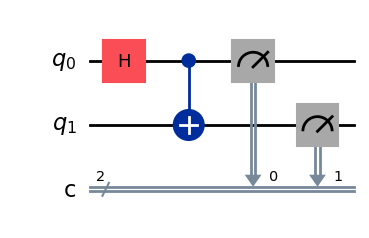

In [2]:
qc = QuantumCircuit(2,2)
qc.h(0) 
qc.cx(0,1) 
qc.measure(0, 0)
qc.measure(1, 1)
qc.draw(output="mpl")

まずはシミュレーターで実験してみます。

{'11': 496, '00': 528}


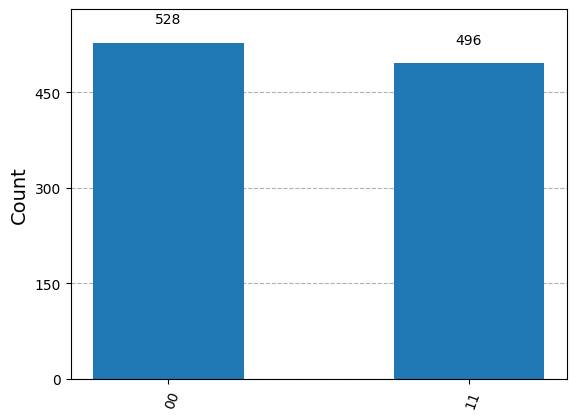

In [3]:
# シミュレーターで実験
backend = AerSimulator()
sampler = Sampler(backend)
job = sampler.run([qc])
result = job.result()

#  測定された回数を表示
counts = result[0].data.c.get_counts()
print(counts)

# ヒストグラムで測定された確率をプロット
plot_histogram( counts )

## 実機で実行する

初めて実機で実行するためには、[IBM Quantum](https://quantum.ibm.com/)のAPIトークンを読み込む必要があります。Openアカウント(無償)の場合のコードを以下に記載します。`<IBM Quantum API key>`の部分に、[IBM Quantumプラットフォーム](https://quantum.ibm.com/)からコピーしてきたAPI Tokenを貼り付けてください。

In [4]:
# 初めて実行する場合は、認証情報を保存します：
# https://quantum.ibm.com/ のAPI Tokenをコピーし貼り付けます
QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='<IBM Quantum API key>')

service = QiskitRuntimeService()
service.backends()

[<IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_nazca')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibm_torino')>,
 <IBMBackend('ibm_brisbane')>]

IBM Quantumプラットフォームの右上あたりの「API Token」から四角が二重になったアイコンをクリックするとコピーできます。

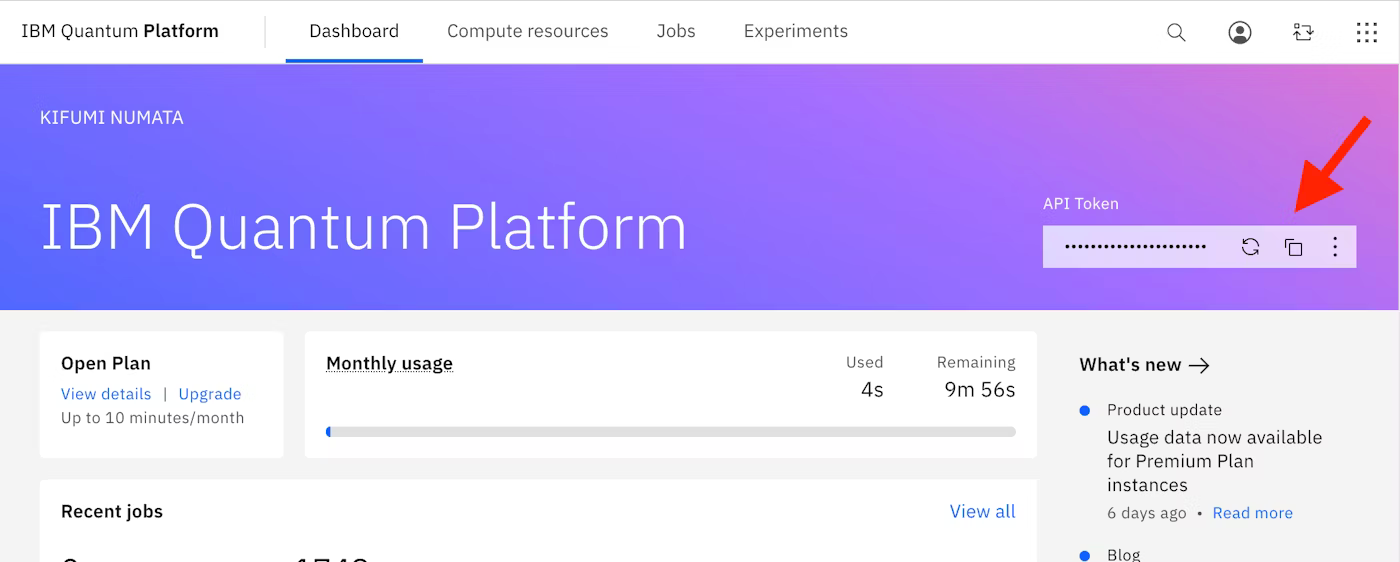

In [5]:
# 以下でデバイスを指定できます。
backend = service.backend('ibm_kyoto')  # 例）ibm_kyotoを使う場合

In [6]:
#一番空いているバックエンドを自動的に選択することもできます
backend = service.least_busy(operational=True)
print("最も空いているバックエンドは: ", backend)

最も空いているバックエンドは:  <IBMBackend('ibm_kyoto')>


In [7]:
# 実機のバックエンドでの実行に最適な回路に変換します
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

# Samplerで実行します
sampler = Sampler(backend)
job = sampler.run([isa_circuit])
print("job id:", job.job_id()) # 実行に時間がかかるのでjob_idを表示します

job id: cvfaxqe8w2g0008eg2q0


以下のコマンドでjobのstatus(実行状況)を確認します。

In [8]:
job = service.job(job.job_id()) 

job.status() # ジョブの実行状態を確認します

'DONE'

In [11]:
# 待ち時間が長い時に後から結果を確認する場合
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()  
job= service.job('cvfaxqe8w2g0008eg2q0') # 例です。上に出力された自分のjob_idを入れて実行してください。
job.status() # ジョブの実行状態を確認します

'DONE'

上記のセルを何回か実行して、'DONE' が表示されたら、実機での実行が終わっているので、以下のセルを実行して結果を確認します。

In [12]:
### 'DONE'になってから実行します ###
result = job.result()
print(result[0].data.c.get_counts())

{'01': 172, '00': 1833, '11': 1797, '10': 294}


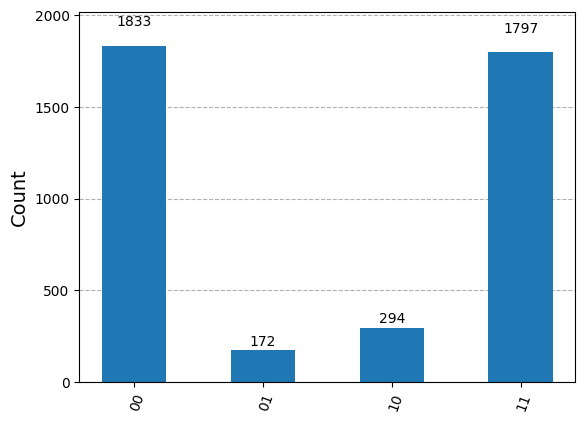

In [13]:
plot_histogram(result[0].data.c.get_counts())

In [14]:
# Qiskitバージョンの確認
import qiskit
qiskit.__version__

'1.1.1'